# 3D radiation dose prediction :

## Imports :

In [1]:
## Imports ##
import sys
import torch
import torch.utils.data as data
import os
import numpy as np
import random
import pandas as pd
import pathlib
### MODEL ###
import torch
import torch.nn as nn
import torch.nn.functional as F

## Dataset

### Loading the data from the github repository

In [2]:
!git clone https://github.com/ababier/open-kbp.git

Cloning into 'open-kbp'...
remote: Enumerating objects: 4229, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 4229 (delta 24), reused 49 (delta 23), pack-reused 4175
Receiving objects: 100% (4229/4229), 523.56 MiB | 17.96 MiB/s, done.
Resolving deltas: 100% (1579/1579), done.
Updating files: 100% (4016/4016), done.


### Definition of general functions

In [3]:
## General functions ##

def load_file(file_name):
    """Load a file in one of the formats provided in the OpenKBP dataset
    :param file_name: the name of the file to be loaded
    :return: the file loaded
    """
    # Load the file as a csv
    loaded_file_df = pd.read_csv(file_name, index_col=0)
    # If the csv is voxel dimensions read it with numpy
    if 'voxel_dimensions.csv' in file_name:
        loaded_file = np.loadtxt(file_name)
    # Check if the data has any values
    elif loaded_file_df.isnull().values.any():
        # Then the data is a vector, which we assume is for a mask of ones
        loaded_file = np.array(loaded_file_df.index).squeeze()
    else:
        # Then the data is a matrix of indices and data points
        loaded_file = {'indices': np.array(loaded_file_df.index).squeeze(),
                       'data': np.array(loaded_file_df['data']).squeeze()}

    return loaded_file

def get_paths(directory_path, ext=''):
    """Get the paths of every file with a specified extension in a directory
    :param directory_path: the path of the directory of interest
    :param ext: the extensions of the files of interest
    :return: the path of all files of interest
    """
    # if dir_name doesn't exist return an empty array
    if not os.path.isdir(directory_path):
        return []
    # Otherwise dir_name exists and function returns contents name(s)
    else:
        all_image_paths = []
        # If no extension given, then get all files
        if ext == '':
            dir_list = os.listdir(directory_path)
            for iPath in dir_list:
                if '.' != iPath[0]:  # Ignore hidden files
                    all_image_paths.append('{}/{}'.format(directory_path, str(iPath)))
        else:
            # Get list of paths for files with the extension ext
            data_root = pathlib.Path(directory_path)
            for iPath in data_root.glob('*.{}'.format(ext)):
                all_image_paths.append(str(iPath))

    return all_image_paths

### Pre-processing functions :

In [4]:
### METHODS TO READ DATA IN ###
# Pre-processing method: correctly aligns the images
# and concatenates them into one list
def pre_processing(dict_images):
    
    # Data in OpenKBP dataset is (h, w, -z, c) or (y, x, -z, c)
    # Change to (c, z, x, y)
    OAR_all = dict_images['structure_masks'][:,:,::-1,:].transpose(3,2,1,0)
    CT = dict_images['ct'][:,:,::-1,:].transpose(3,2,1,0)
    dose = dict_images['dose'][:,:,::-1,:].transpose(3,2,1,0)
    possible_dose_mask = dict_images['possible_dose_mask'][:,:,::-1,:].transpose(3,2,1,0)

    # list_images = [np.concatenate((OAR_all, CT), axis=0),  # Input
    #                dose,  # Label
    #                possible_dose_mask]

    input = np.concatenate((CT, OAR_all, possible_dose_mask), axis=0)
    # input = np.stack([OAR_all, CT, possible_dose_mask], axis=0)
    # input = np.array([input])
    list_images = [input,  # Input
                   dose,  # Label
                   possible_dose_mask]


    return list_images

# Custom dataset: fetches correct patiets per phase
# and pre-processes with above method
class MyDataset(data.Dataset):
    def __init__(self, num_samples_per_epoch, phase):
        # 'train' or 'val'
        self.phase = phase
        self.num_samples_per_epoch = num_samples_per_epoch

        self.list_case_id = {'train': ['/content/open-kbp/provided-data/train-pats/pt_' + str(i) for i in range(1, 201)],
                             'val': ['/content/open-kbp/provided-data/validation-pats/pt_' + str(i) for i in range(201, 241)],
                             'test': ['/content/open-kbp/provided-data/test-pats/pt_' + str(i) for i in range(241, 341)]}[phase]
        random.shuffle(self.list_case_id)
        self.dl = DataLoader(self.list_case_id)
        self.sum_case = len(self.list_case_id)

    def __getitem__(self, index_):
        dict_images = self.dl.load_and_shape_data(self.list_case_id[index_])
        list_images = pre_processing(dict_images)
        for i in range(len(list_images)):
            list_images[i] = torch.from_numpy(list_images[i].copy()).float()
        return list_images

    def __len__(self):
        return self.num_samples_per_epoch

# Method to get loader: builds dataloaders using custom dataset
# num_samples_per_epoch indiciates how many samples are looked at
# per epoch. 
def get_loader(train_bs=1, val_bs=1, train_num_samples_per_epoch=4, val_num_samples_per_epoch=4, num_works=0):
    train_dataset = MyDataset(num_samples_per_epoch=train_num_samples_per_epoch, phase='train')
    val_dataset = MyDataset(num_samples_per_epoch=val_num_samples_per_epoch, phase='val')

    train_loader = data.DataLoader(dataset=train_dataset, batch_size=train_bs, shuffle=True, num_workers=num_works,
                                   pin_memory=False)
    val_loader = data.DataLoader(dataset=val_dataset, batch_size=val_bs, shuffle=False, num_workers=num_works,
                                 pin_memory=False)

    return train_loader, val_loader


### DataLoader Creation :

In [5]:
## DataLoader ##

class DataLoader:
    def __init__(self, file_paths_list, batch_size=2, patient_shape=(128, 128, 128), shuffle=True,
                 mode_name='training_model'):
        """Initialize the DataLoader class, which loads the data for OpenKBP
        :param file_paths_list: list of the directories or single files where data for each patient is stored
        :param batch_size: the number of data points to lead in a single batch
        :param patient_shape: the shape of the patient data
        :param shuffle: whether or not order should be randomized
        """
        # Set file_loader specific attributes
        self.rois = dict(oars=['Brainstem', 'SpinalCord', 'RightParotid', 'LeftParotid',
                               'Esophagus', 'Larynx', 'Mandible'], targets=['PTV56', 'PTV63', 'PTV70'])

        self.batch_size = batch_size  # Number of patients to load in a single batch
        self.patient_shape = patient_shape  # Shape of the patient

        
        self.indices = np.arange(len(file_paths_list))  # Indices of file paths
        self.file_paths_list = file_paths_list  # List of file paths
        self.shuffle = shuffle  # Indicator as to whether or not data is shuffled
        self.full_roi_list = sum(map(list, self.rois.values()), [])  # make a list of all rois
        self.num_rois = len(self.full_roi_list)
        self.patient_id_list = ['pt_{}'.format(k.split('/pt_')[1].split('/')[0].split('.csv')[0]) for k in
                                self.file_paths_list]  # the list of patient ids with information in this data loader

        # Set files to be loaded
        self.required_files = None
        self.mode_name = mode_name  # Defines the mode for which data must be loaded for
        self.set_mode(self.mode_name)  # Set load mode to prediction by default

    def get_batch(self, index=None, patient_list=None):
        """Loads one batch of data
        :param index: the index of the batch to be loaded
        :param patient_list: the list of patients for which to load data for
        :return: a dictionary with the loaded data
        """

        if patient_list is None:
            # Generate batch based on the provided index
            indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        else:
            # Generate batch based on the request patients
            indices = self.patient_to_index(patient_list)

        # Make a list of files to be loaded
        file_paths_to_load = [self.file_paths_list[k] for k in indices]

        # Load the requested files as a tensors
        loaded_data = self.load_data(file_paths_to_load)
        return loaded_data

    def patient_to_index(self, patient_list):
        """Converts a list of patient ids to their appropriate indices
        :param patient_list: list of patient ids
        :return: list of indices for the requested patients
        """
        # Get the indices for the list that is not shuffled
        un_shuffled_indices = [self.patient_id_list.index(k) for k in patient_list]

        # Map the indices to the shuffled indices to the shuffled indices
        shuffled_indices = [self.indices[k] for k in un_shuffled_indices]

        return shuffled_indices

    def set_mode(self, mode_name, single_file_name=None):
        """Selects the type of data that is loaded
        :param mode_name: the name of the mode that the data loader is switching to
        :param single_file_name: the name of the file that should be loaded (only used if the mode_name is 'single_file')
        """
        self.mode_name = mode_name

        if mode_name == 'training_model':
            # The mode that should be used when training or validing a model
            self.required_files = {'dose': (self.patient_shape + (1,)),  # The shape of dose tensor
                                   'ct': (self.patient_shape + (1,)),  # The shape of ct tensor
                                   'structure_masks': (self.patient_shape + (self.num_rois,)),
                                   # The shape of the structure mask tensor
                                   'possible_dose_mask': (self.patient_shape + (1,)),
                                   # Mask of where dose can be deposited
                                   'voxel_dimensions': (3,)
                                   # Physical dimensions (in mm) of voxels
                                   }
        elif mode_name == 'dose_prediction':
            # The mode that should be used when training or validing a model
            self.required_files = {'ct': (self.patient_shape + (1,)),  # The shape of ct tensor
                                   'structure_masks': (self.patient_shape + (self.num_rois,)),
                                   # The shape of the structure mask tensor
                                   'possible_dose_mask': (self.patient_shape + (1,)),
                                   # Mask of where dose can be deposited
                                   'voxel_dimensions': (3,)  # Physical dimensions (in mm) of voxels
                                   }
            self.batch_size = 1
            print('Warning: Batch size has been changed to 1 for dose prediction mode')

        elif mode_name == 'predicted_dose':
            # This mode loads a single feature (e.g., dose, masks for all structures)
            self.required_files = {mode_name: (self.patient_shape + (1,))}  # The shape of a dose tensor

        elif mode_name == 'evaluation':
            # The mode that should be used evaluate the quality of predictions
            self.required_files = {'dose': (self.patient_shape + (1,)),  # The shape of dose tensor
                                   'structure_masks': (self.patient_shape + (self.num_rois,)),
                                   'voxel_dimensions': (3,),  # Physical dimensions (in mm) of voxels
                                   'possible_dose_mask': (self.patient_shape + (1,)),
                                   }
            self.batch_size = 1
            print('Warning: Batch size has been changed to 1 for evaluation mode')

        else:
            print('Mode does not exist. Please re-run with either \'training_model\', \'prediction\', '
                  '\'predicted_dose\', or \'evaluation\'')

    def number_of_batches(self):
        """Calculates how many full batches can be made in an epoch
        :return: the number of batches that can be loaded
        """
        return int(np.floor(len(self.file_paths_list) / self.batch_size))

    def on_epoch_end(self):
        """Randomizes the indices after each epoch"""
        if self.shuffle:
            np.random.shuffle(self.indices)

    def load_data(self, file_paths_to_load):
        """Generates data containing batch_size samples X : (n_samples, *dim, n_channels)
        :param file_paths_to_load: the paths of the files to be loaded
        :return: a dictionary of all the loaded files
        """

        # Initialize dictionary for loaded data and lists to track patient path and ids
        tf_data = {}.fromkeys(self.required_files)
        patient_list = []
        patient_path_list = []

        # Loop through each key in tf data to initialize the tensor with zeros
        for key in tf_data:
            # Make dictionary with appropriate data sizes for bath learning
            tf_data[key] = np.zeros((self.batch_size, *self.required_files[key]))

        # Generate data
        for i, pat_path in enumerate(file_paths_to_load):
            # Get patient ID and location of processed data to load
            patient_path_list.append(pat_path)
            pat_id = pat_path.split('/')[-1].split('.')[0]
            patient_list.append(pat_id)
            # Make a dictionary of all the tensors
            loaded_data_dict = self.load_and_shape_data(pat_path)
            # Iterate through the dictionary add the loaded data to the "batch channel"
            for key in tf_data:
                tf_data[key][i,] = loaded_data_dict[key]

        # Add two keys to the tf_data dictionary to track patient information
        tf_data['patient_list'] = patient_list
        tf_data['patient_path_list'] = patient_path_list

        return tf_data

    def load_and_shape_data(self, path_to_load):
        """ Reshapes data that is stored as vectors into matrices
        :param path_to_load: the path of the data that needs to be loaded. If the path is a directory, all data in the
         directory will be loaded. If path is a file then only that file will be loaded.
        :return: Loaded data with the appropriate shape
        """

        # Initialize the dictionary for the loaded files
        loaded_file = {}
        if '.csv' in path_to_load:
            loaded_file[self.mode_name] = load_file(path_to_load)
        else:
            files_to_load = get_paths(path_to_load, ext='')
            # Load files and get names without file extension or directory
            for f in files_to_load:
                f_name = f.split('/')[-1].split('.')[0]
                if f_name in self.required_files or f_name in self.full_roi_list:
                    loaded_file[f_name] = load_file(f)

        # Initialize matrices for features
        shaped_data = {}.fromkeys(self.required_files)
        for key in shaped_data:
            shaped_data[key] = np.zeros(self.required_files[key])

        # Populate matrices that were no initialized as []
        for key in shaped_data:
            if key == 'structure_masks':
                # Convert dictionary of masks into a tensor (necessary for tensorflow)
                for roi_idx, roi in enumerate(self.full_roi_list):
                    if roi in loaded_file.keys():
                        np.put(shaped_data[key], self.num_rois * loaded_file[roi] + roi_idx, int(1))
            elif key == 'possible_dose_mask':
                np.put(shaped_data[key], loaded_file[key], int(1))
            elif key == 'voxel_dimensions':
                shaped_data[key] = loaded_file[key]
            else:  # Files with shape
                np.put(shaped_data[key], loaded_file[key]['indices'], loaded_file[key]['data'])

        return shaped_data

## Network Creation :

In [6]:
def get_activation(activation_type):
  activation_type = activation_type.lower()
  if hasattr(nn, activation_type):  return getattr(nn, activation_type)()
  else:  return nn.ReLU()


In [8]:
class ConvBatchNorm3D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1,
                 bias=True, activation_type='ReLU'):
        super(ConvBatchNorm3D, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
        self.norm = nn.BatchNorm3d(out_channels)
        self.activation = get_activation(activation_type)

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.activation(x)
        return x


In [9]:
def _make_nConv3D(in_channels, out_channels, nb_Conv, activation='ReLU'):
    layers = []
    for i in range(nb_Conv):
        layers.append(ConvBatchNorm3D(in_channels, out_channels, kernel_size=3, stride=1, padding=1,
                                      activation_type=activation))
        in_channels = out_channels
    return nn.Sequential(*layers)

### Implementation of the ResBlock :

In [7]:
class Resblock3D(nn.Module):
    def __init__(self,in_channels, out_channels, activation = 'relu'):
        super(Resblock3D, self).__init__()
        
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(in_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.activation = get_activation(activation)
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm3d(out_channels)
            )
        
    def forward(self, x):
        out = self.bn1(x)
        out = self.activation(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.activation(out)
        out = self.conv2(out)
        out += self.shortcut(x)
        return out

### Implementation of DownBlock / Bottleneck / UpBlock :





In [10]:
## Downblock 

class DownBlock(nn.Module):
    """This implements a downblock"""
    def __init__(self, in_channels, out_channels, nb_Conv, activation='ReLU'):
        super(DownBlock, self).__init__()
        self.maxpool = nn.MaxPool3d(kernel_size=2, stride=2)
        self.nConvs = _make_nConv3D(in_channels, out_channels, nb_Conv, activation)

    def forward(self, x):
        x = self.nConvs(x)
        return self.maxpool(x)

class Bottleneck(nn.Module):
    """This implements a bottleneck"""
    def __init__(self, in_channels, out_channels, nb_Conv, activation='ReLU'):
        super(Bottleneck, self).__init__()
        self.nConvs = _make_nConv3D(in_channels, out_channels, nb_Conv, activation)

    def forward(self, input):
        return self.nConvs(input)

class UpBlock(nn.Module):
    """This implements an upblock"""
    def __init__(self, in_channels, out_channels, nb_Conv, activation='ReLU'):
        super(UpBlock, self).__init__()
        ## upsampling for 3D 
        self.up = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
        self.nConvs = _make_nConv3D(in_channels, out_channels, nb_Conv, activation)

    def forward(self, x, skip_x):
        out = self.up(x)
        x = torch.cat([out, skip_x], dim=1)
        return self.nConvs(x)



### U-net3D architecture :

In [11]:
## Unet 

class UNet(nn.Module):
    """This implements a UNet"""
    def __init__(self, n_channels, n_classes, nb_Conv = 2):
        super(UNet, self).__init__()
        ## init 
        self.in_channels = n_channels
        self.out_channels = n_classes
        # self.inc = ConvBatchNorm3D(self.in_channels, 16, kernel_size=3, stride=1, padding=1)
        self.inc = Resblock3D(self.in_channels, 16)

        ## down
        self.down1 = DownBlock(16, 32, nb_Conv)
        self.down2 = DownBlock(32, 64, nb_Conv)
        self.down3 = DownBlock(64, 128, nb_Conv)
        self.down4 = DownBlock(128, 256, nb_Conv)


        self.Encoder = [self.down1, self.down2, self.down3, self.down4]

        ## bottleneck
        self.bottleneck = Bottleneck( 256, 256, nb_Conv)

        ## up 
        self.up1 = UpBlock(256, 128, nb_Conv)
        self.up2 = UpBlock(128, 64, nb_Conv)
        self.up3 = UpBlock(64, 32, nb_Conv)
        self.up4 = UpBlock(32, 16, nb_Conv)


        self.Decoder = [self.up1, self.up2, self.up3, self.up4]

        ## out
        self.outc = ConvBatchNorm3D(16, self.out_channels, kernel_size=1, stride=1, padding=0)
        self.last_activation = get_activation('ReLU')

    

    def forward(self, x):
        x = self.inc(x)
        skip_inputs = [x]

        ## forward encoder
        for i, block in enumerate(self.Encoder):
            x = block(x)
            skip_inputs += [x] 
            ## dropout
            x = F.dropout(x, p=0.5, training=self.training)   

        ## bottleneck
        bottleneck = self.bottleneck(x)
        bottleneck = F.dropout(bottleneck, p=0.5, training=self.training)

    
        ## forward decoder
        skip_inputs.reverse()
        decoded = bottleneck
        for i, block in enumerate(self.Decoder):
            skipped = skip_inputs[i+1]
            decoded = block(decoded, skipped)
            decoded = F.dropout(decoded, p=0.5, training=self.training)

            
        ## out
        x = self.last_activation(self.outc(decoded))
        return x



In [12]:
## test out the model

model = UNet(n_channels=12, n_classes=1, nb_Conv=2)
print(model)


UNet(
  (inc): Resblock3D(
    (conv1): Conv3d(12, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (bn1): BatchNorm3d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (bn2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
    (shortcut): Sequential(
      (0): Conv3d(12, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (down1): DownBlock(
    (maxpool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (nConvs): Sequential(
      (0): ConvBatchNorm3D(
        (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (norm): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

## Training of our model :



In [13]:
### TRAINING LOOP ###
import time

# Function to train the model: Takes in
# a model, dataloader, optimizer, scheduler, and loss function.
# num_epochs controls max number of epochs the loop is run for
# verbose for logging
def train_model(model, dataloader, optimizer, scheduler, loss_fn, num_epochs = 50, verbose = False):
    loss_dict = {'train':[],'val':[]}
    best_loss = 500
    phases = ['train','val']
    since = time.time()
    for i in range(num_epochs):
        if verbose or (i%10 == 0):
            print('Epoch: {}/{}'.format(i+1, num_epochs))
            print('-'*10)
        for p in phases:
            running_loss = 0
            running_total = 0
            if p == 'train':
                model.train()
            else:
                model.eval()
                
            for data in dataloader[p]:
                optimizer.zero_grad()
                image = data[0].to(device)
                dose = data[1].to(device)
                pdm = data[2].to(device) ## 
                label = dose 
                output = model(image)
                loss = loss_fn(output, label)
                num_imgs = image.size()[0]
                running_loss += loss.item()*num_imgs
                running_total += num_imgs
                if p== 'train':
                    loss.backward()
                    optimizer.step()
            epoch_loss = float(running_loss/running_total)
            if verbose or (i%10 == 0):
                print('Phase:{}, epoch loss: {:.4f}'.format(p, epoch_loss))
            
            loss_dict[p].append(epoch_loss)
            if p == 'val':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = model.state_dict()
            else:
                if scheduler:
                    scheduler.step()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))
    if p == 'val':
        model.load_state_dict(best_model_wts)
    
    return model, loss_dict

In [14]:
torch.cuda.empty_cache()

In [15]:
### Define model, loss, optimizer, scheduler, dataloader for training loop ###
# model = Model(in_ch=11, out_ch=1, list_ch=[-1, 16, 32, 64, 128, 256])
torch.cuda.empty_cache()

model = UNet(n_channels=12, n_classes=1)
device = torch.device('cuda')
# model = nn.DataParallel(model)
model.to(device)

loss = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-2, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=80000, eta_min=1e-7, last_epoch=-1)
bs = 1
dataloader = {}
dataloader['train'] , dataloader['val'] = get_loader(
        train_bs=bs,
        val_bs=bs,
        train_num_samples_per_epoch=200,  
        val_num_samples_per_epoch=40,
        num_works=0
    )

In [16]:
### Train the model, 50 epochs ###
model, loss_dict = train_model(model, dataloader, optimizer, scheduler, loss, num_epochs=15, verbose = True) 

Epoch: 1/15
----------
Phase:train, epoch loss: 1.2939
Phase:val, epoch loss: 1.4896
Epoch: 2/15
----------
Phase:train, epoch loss: 1.0266
Phase:val, epoch loss: 1.0400
Epoch: 3/15
----------
Phase:train, epoch loss: 0.8417
Phase:val, epoch loss: 0.7039
Epoch: 4/15
----------
Phase:train, epoch loss: 0.7379
Phase:val, epoch loss: 0.5060
Epoch: 5/15
----------
Phase:train, epoch loss: 0.6919
Phase:val, epoch loss: 0.7028
Epoch: 6/15
----------
Phase:train, epoch loss: 0.6622
Phase:val, epoch loss: 1.2259
Epoch: 7/15
----------
Phase:train, epoch loss: 0.6759
Phase:val, epoch loss: 0.3895
Epoch: 8/15
----------
Phase:train, epoch loss: 0.6511
Phase:val, epoch loss: 0.3779
Epoch: 9/15
----------
Phase:train, epoch loss: 0.6459
Phase:val, epoch loss: 0.6874
Epoch: 10/15
----------
Phase:train, epoch loss: 0.6402
Phase:val, epoch loss: 0.5726
Epoch: 11/15
----------
Phase:train, epoch loss: 0.6197
Phase:val, epoch loss: 0.3733
Epoch: 12/15
----------
Phase:train, epoch loss: 0.6056
Phase:v

In [17]:
### Save model locally, name reflects configuration tested ###
torch.save(model,'lr3e-4_model.pkl')

In [ ]:
### Load a saved model ###
checkpoint = torch.load('/content/lr3e-4_model.pkl')
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])

In [18]:
### Also save the losses for ease of access ###
import pickle
f = open('lr3e-4_loss.pkl','wb')
pickle.dump(loss_dict,f)
f.close()

### Evolution of the Training Loss 

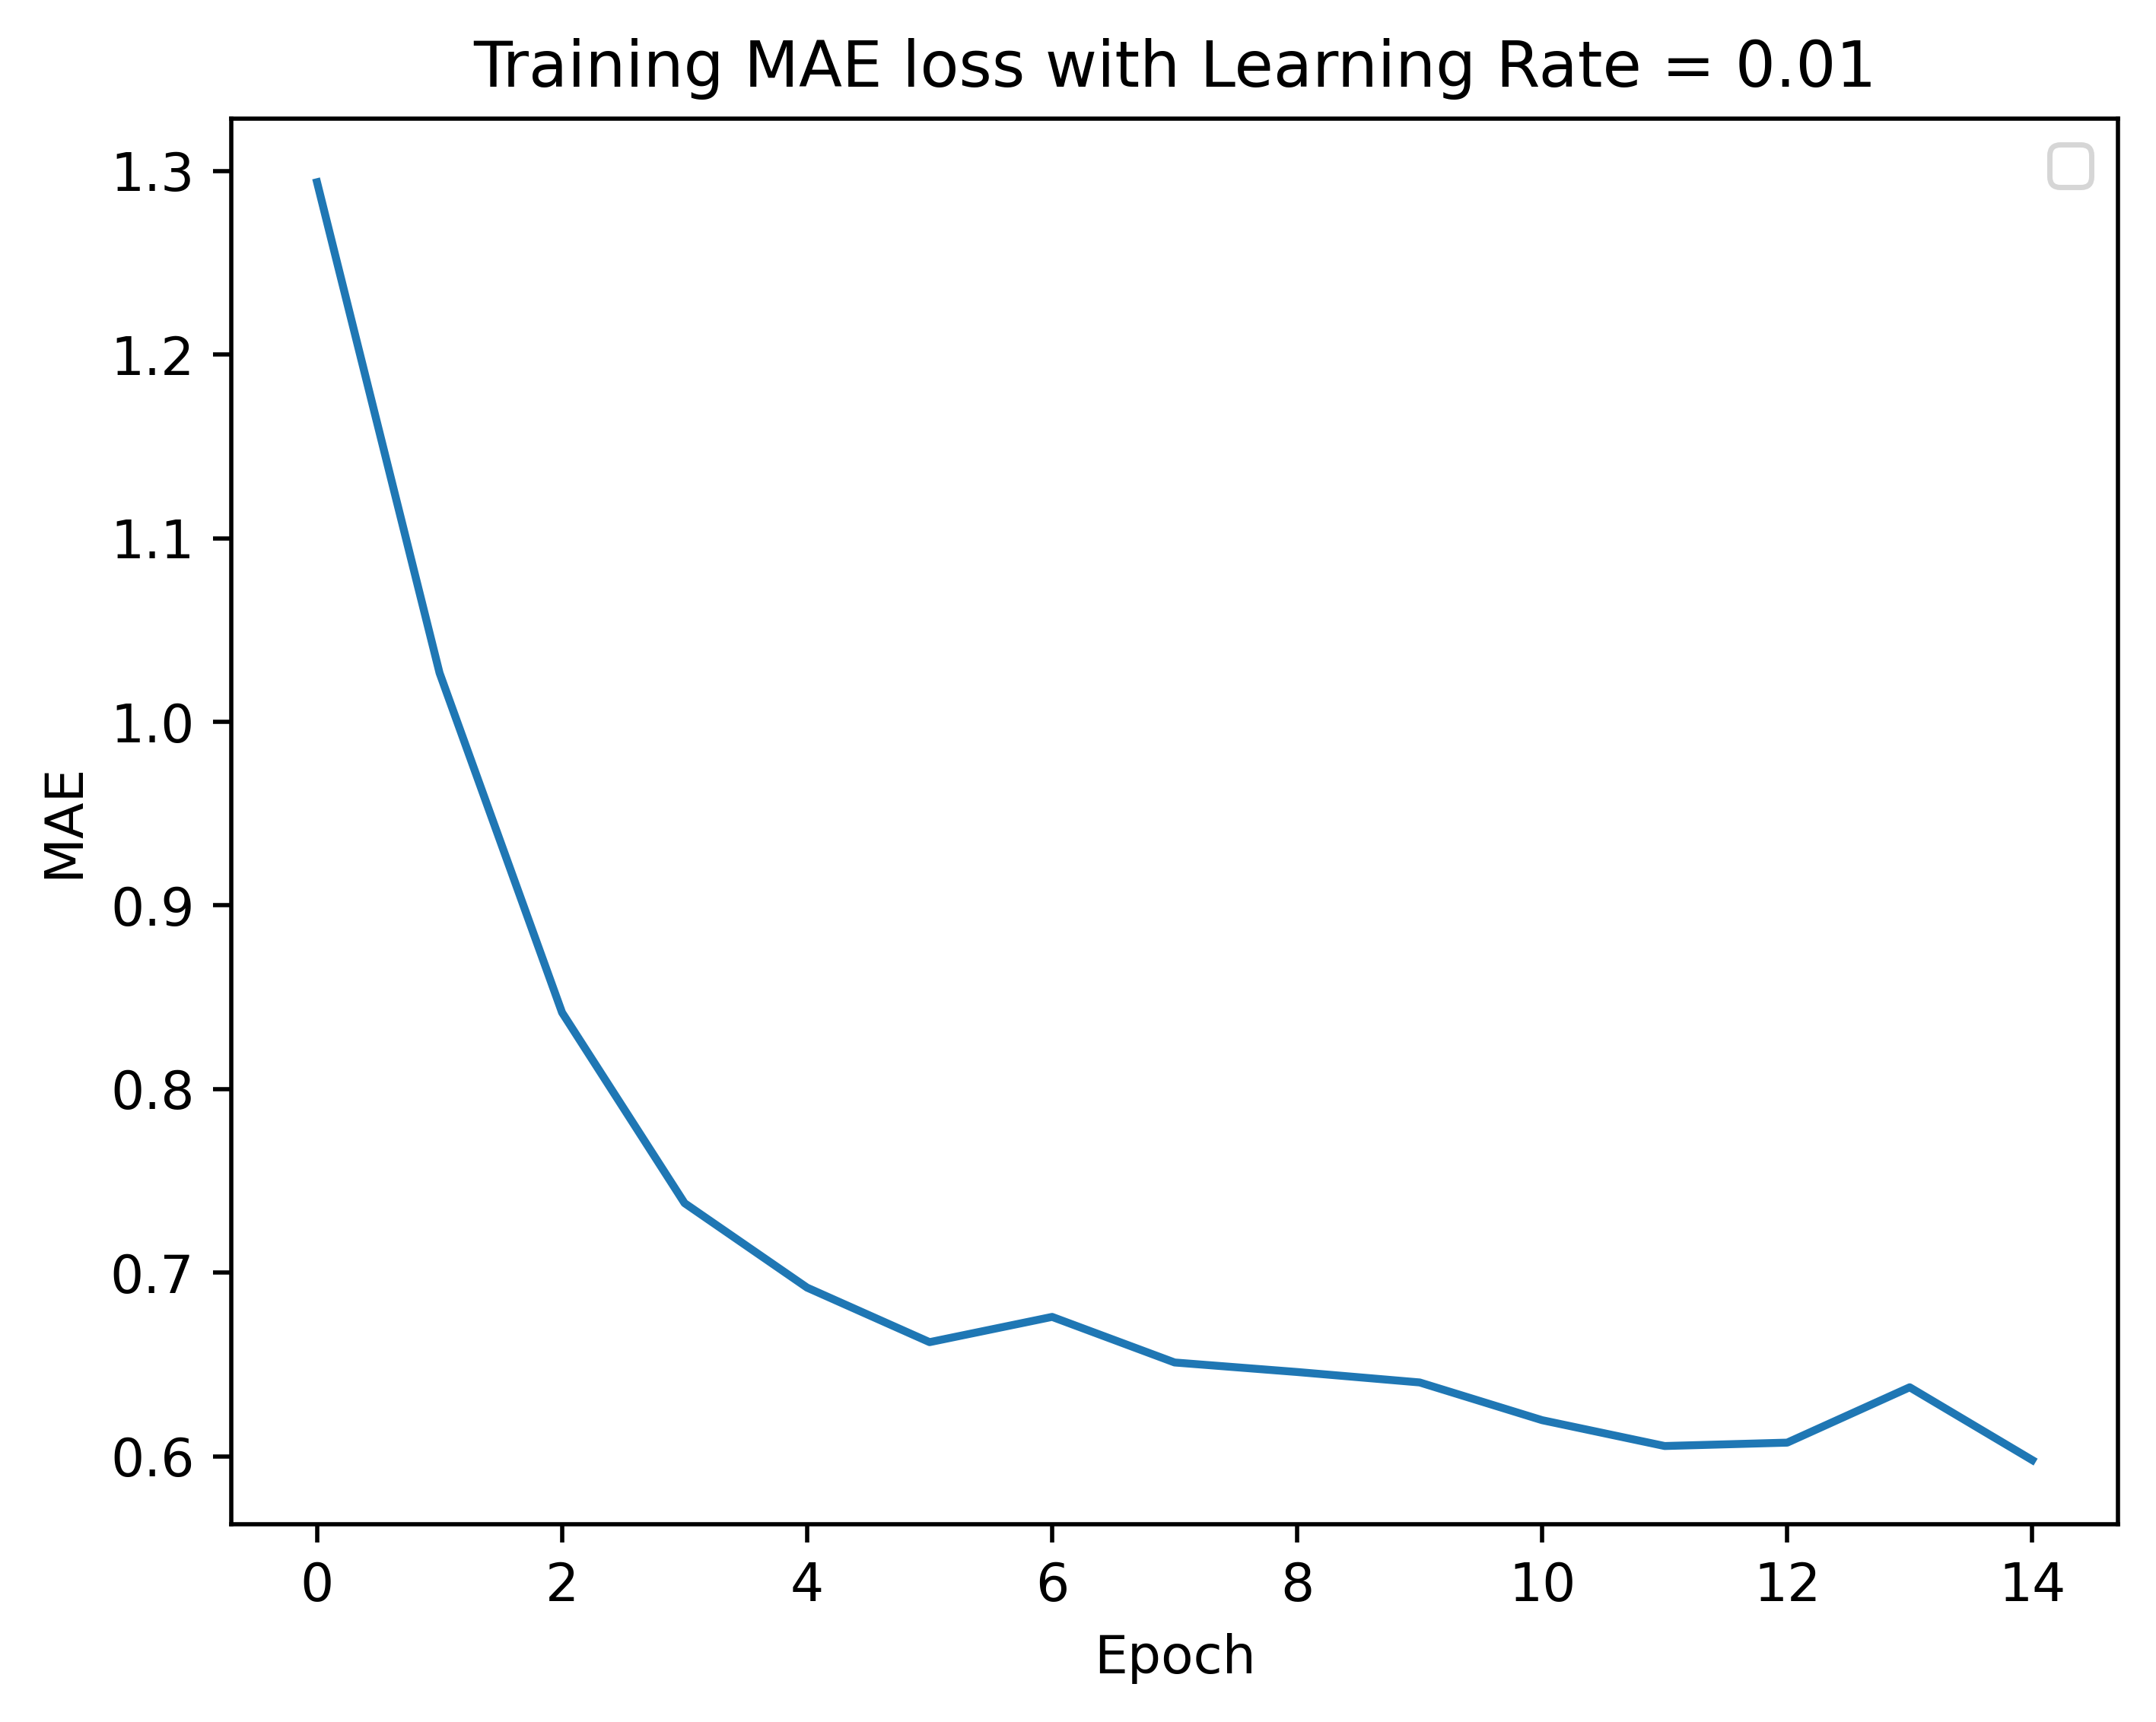

In [35]:
### PLOT LEARNING CURVES ###
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pickle

# Fetch saved loss dictionaries
f = open('lr3e-4_loss.pkl','rb')
bs1 = pickle.load(f)
f.close()
mpl.rcParams['figure.dpi']= 500
x = np.arange(15)

### BATCH SIZE TRAINING ###
plt.plot(x,bs1['train'])
plt.legend()
plt.title('Training MAE loss with Learning Rate = 0.01')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.show()

### Evolution of the Validation Loss

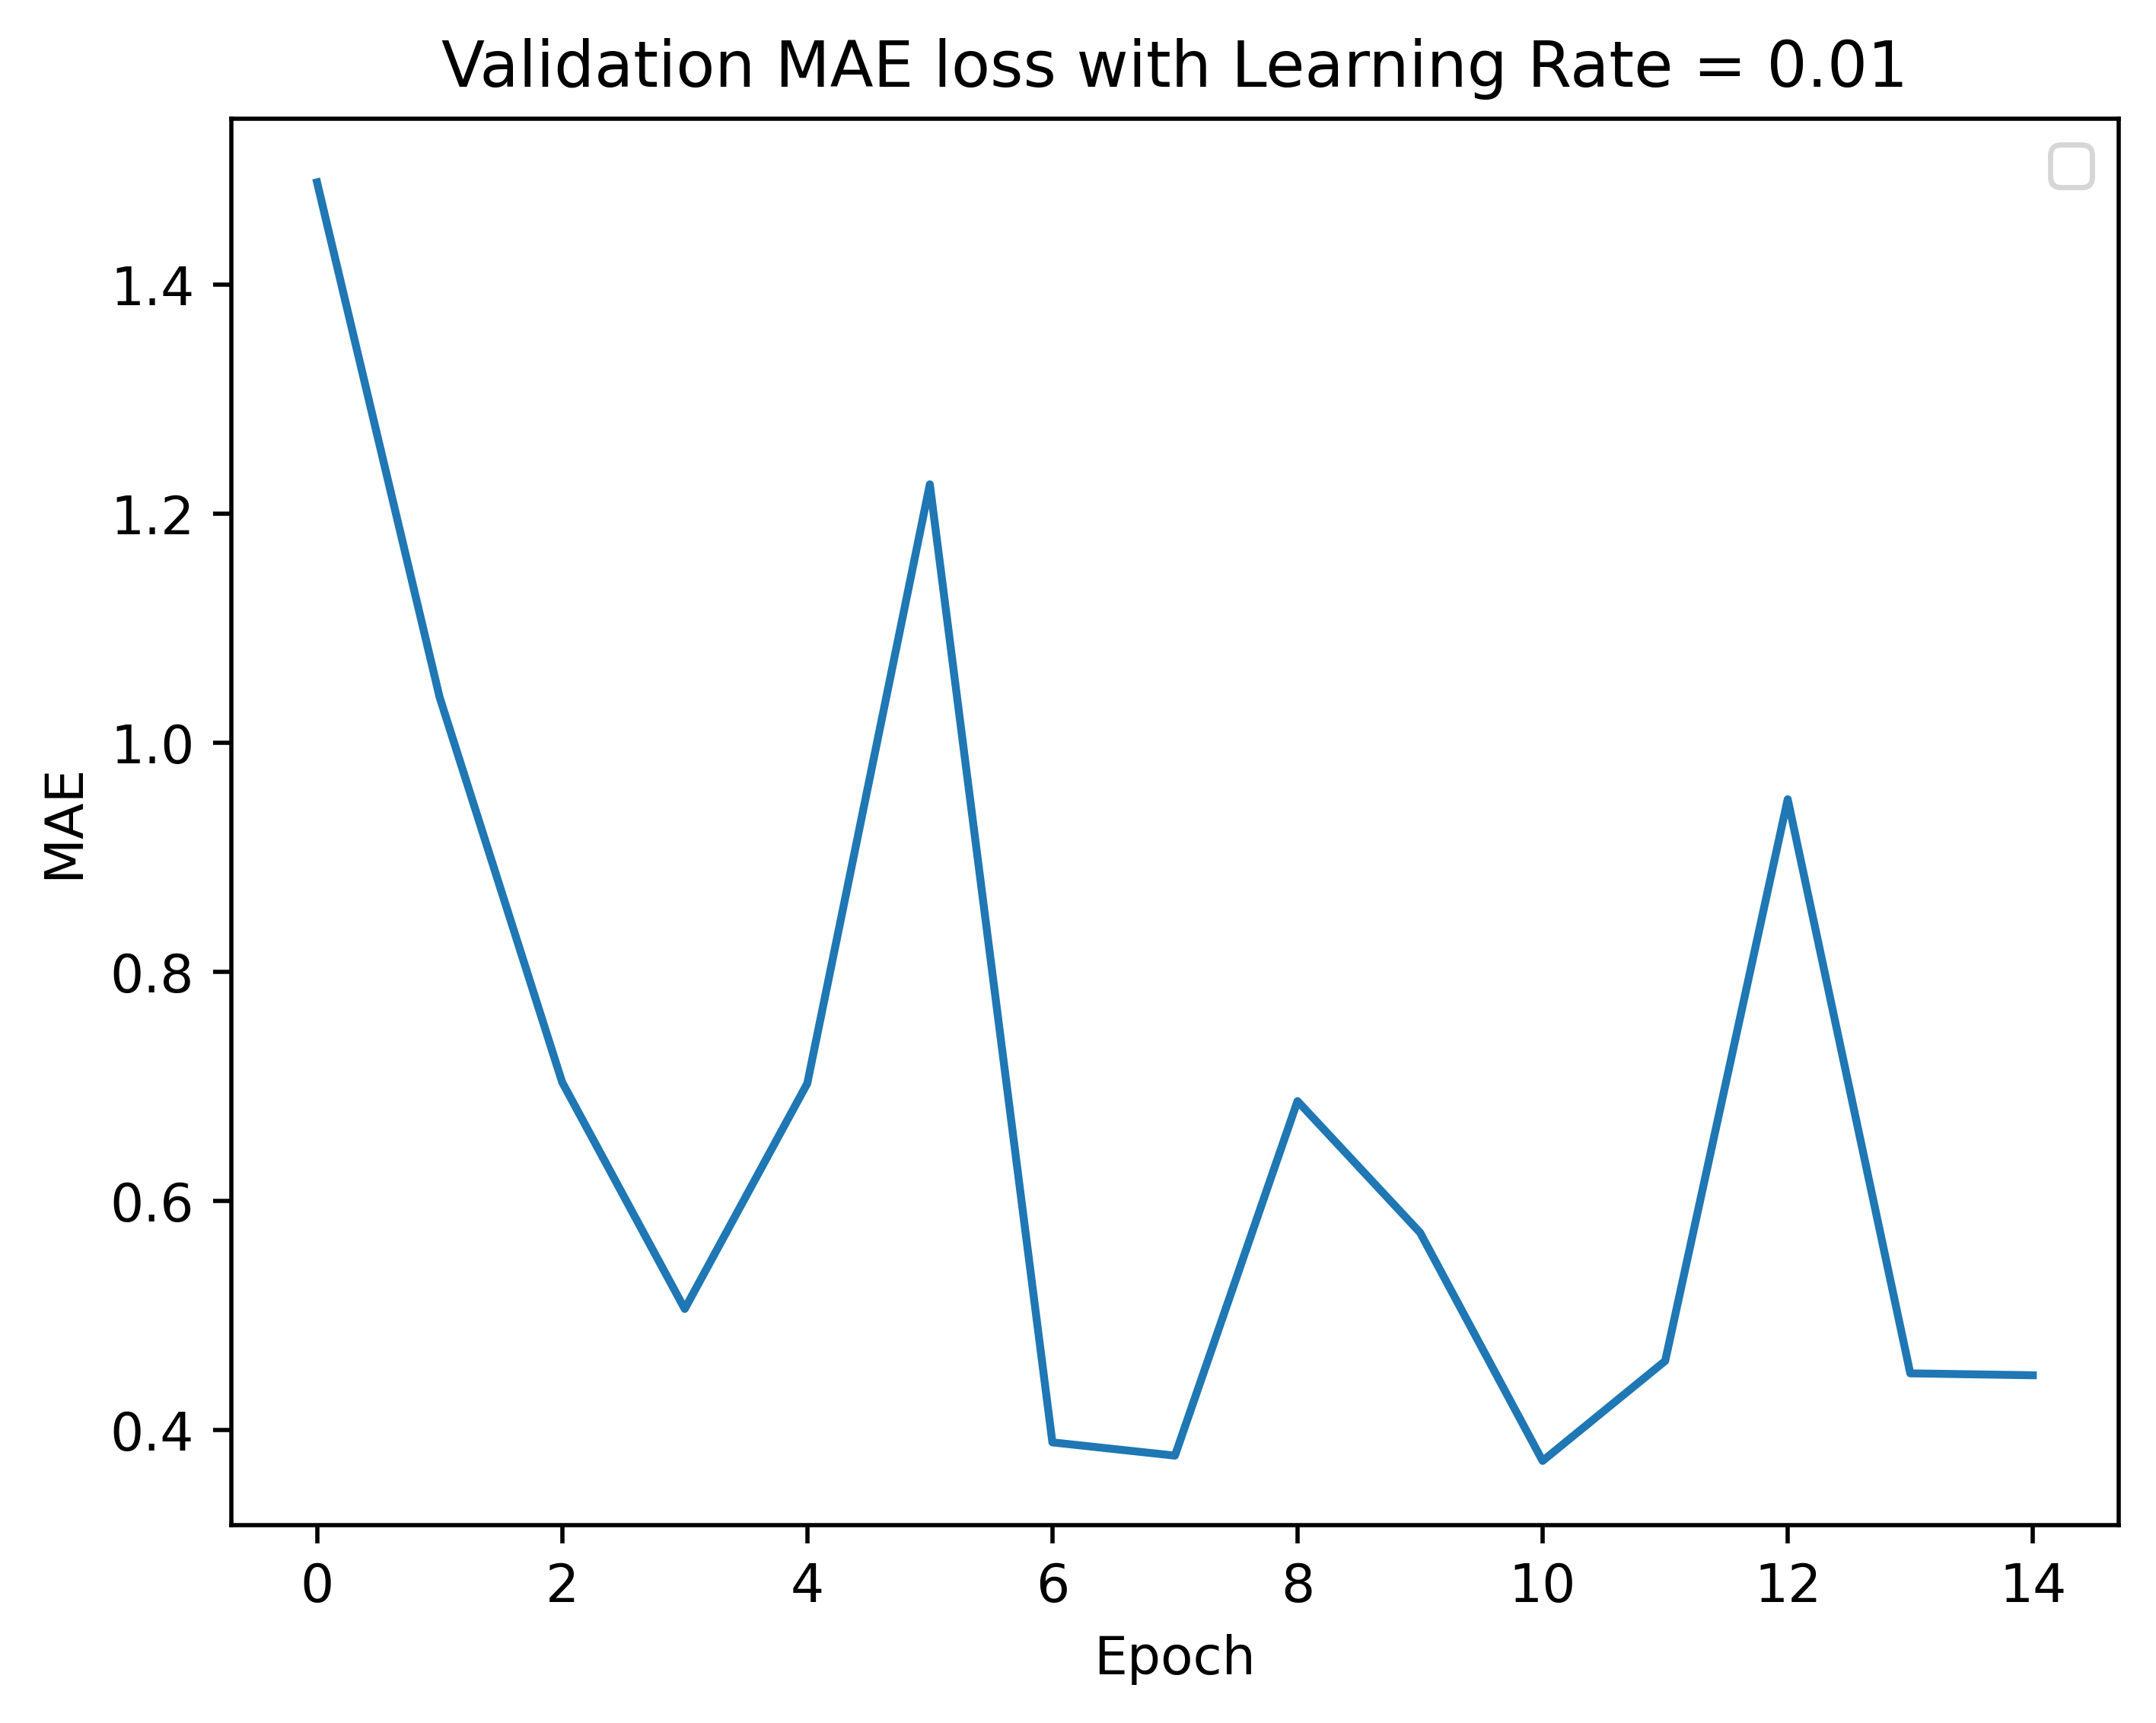

In [34]:
### PLOT LEARNING CURVES ###
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pickle

# Fetch saved loss dictionaries
f = open('lr3e-4_loss.pkl','rb')
bs1 = pickle.load(f)
f.close()
mpl.rcParams['figure.dpi']= 500
x = np.arange(15)

### BATCH SIZE TRAINING ###
plt.plot(x,bs1['val'])
plt.legend()
plt.title('Validation MAE loss with Learning Rate = 0.01')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.show()

## Evaluation of our model :

In [ ]:
# Define test dataset and dataloader
test_dataset = MyDataset(num_samples_per_epoch=100, phase='test')
test_loader = data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=False)

# Empty lists to save images for visualization later: requires a lot of memory
mads = []
cts= []
doses = []
preds = []

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
models = model.to(device)

# Loop over test data
for data in test_loader:
    with torch.no_grad():
        # Get input image and move to device
        image = data[0].to(device)
        
        # Append image and other data to lists
        cts.append(image.cpu().numpy()[0,-1,:,:,:])
        dose = data[1].numpy()        
        pdm = data[2].numpy()
        doses.append(np.where(pdm>0,dose,0))
        preds.append(np.where(pdm>0,dose,0))
        
        # Get model prediction and move to CPU
        pred = models(image).cpu().numpy()  
        pred = pred[pdm > 0]
        dose = dose[pdm > 0]
        
        # Compute mean absolute difference score
        mads.append(np.mean(np.abs(pred-dose)))
        
# Compute dose score
dose_score = np.mean(mads)


In [ ]:
### Print out test dose score ###
print('Dose score is: ' + str(dose_score))

Dose score is: 8.039377
